StockCode:00001
Start_date(yyyy/mm/dd):2022/06/12
End_date:(yyyy/mm/dd)2022/07/25


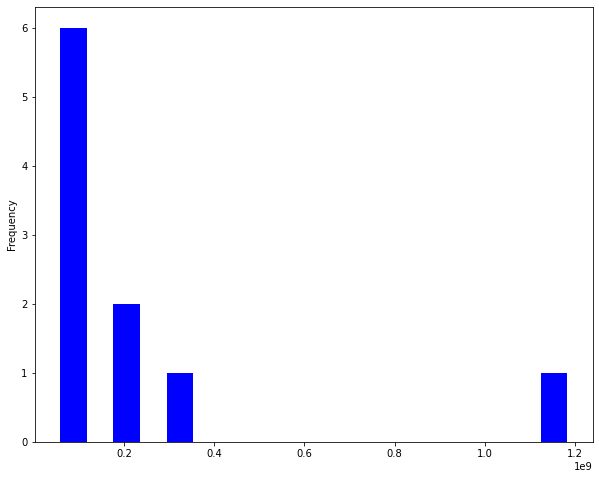

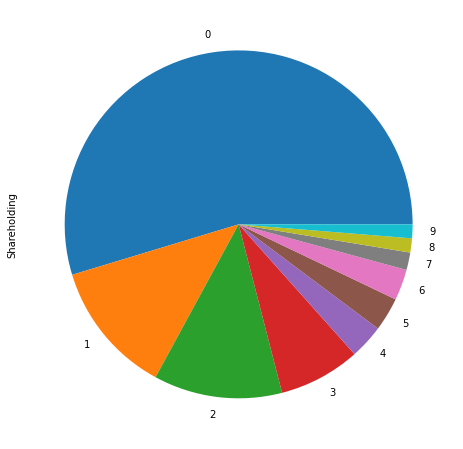

,Participant ID,Name of CCASS Participant (* for Consenting Investor Participants ),Address,Shareholding,% of the total number of Issued Shares/ Warrants/ Units
0,C00019,THE HONGKONG AND SHANGHAI BANKING,HSBC WEALTH BUSINESS SERVICES 8/F TOWER 2 & 3 ...,1211922199,31.60%
1,C00100,"JPMORGAN CHASE BANK, NATIONAL",18/F TOWER 2 THE QUAYSIDE 77 HOI BUN ROAD KWUN...,274681952,7.16%
2,C00010,CITIBANK N.A.,9/F CITI TOWER ONE BAY EAST 83 HOI BUN ROAD KW...,264668236,6.90%
3,C00039,STANDARD CHARTERED BANK (HONG KONG) LTD,18/F STANDARD CHARTERED BANK TOWER MILLENNIUM ...,168066474,4.38%
4,C00033,BANK OF CHINA (HONG KONG) LTD,11/F BANK OF CHINA CENTRE OLYMPIAN CITY 11 HOI...,70375270,1.83%
5,C00018,HANG SENG BANK LTD,16/F HANG SENG 113 113 ARGYLE STREET MONGKOK K...,69235433,1.80%
6,B01161,UBS SECURITIES HONG KONG LTD,47-52/F TWO INTERNATIONAL FINANCE CENTRE 8 FIN...,63802224,1.66%
7,B01284,HANG SENG SECURITIES LTD,16/F HANG SENG 113 113 ARGYLE STREET MONGKOK K...,35936701,0.93%
8,C00093,BNP PARIBAS SECURITIES SERVICES,21/F PCCW TOWER TAIKOO PLACE 979 KING'S ROAD Q...,29151517,0.76%
9,C00074,DEUTSCHE BANK AG,60/F INTERNATIONAL COMMERCE CENTRE 1 AUSTIN RO...,28413952,0.74%


In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

URL = "https://www3.hkexnews.hk/sdw/search/searchsdw.aspx"
l = []
StockCode = input('StockCode:')
Start_date = input('Start_date(yyyy/mm/dd):')
End_date = input('End_date:(yyyy/mm/dd)')
with requests.Session() as s:
    s.headers={"User-Agent":"Mozilla/5.0"}
    res = s.get(URL)
    soup = BeautifulSoup(res.text,"lxml")
    payload = {item['name']:item.get('value','') for item in soup.select("input[name]")}
    payload['__EVENTTARGET'] = 'btnSearch'
    payload['txtShareholdingDate'] = End_date
    payload['txtStockCode'] = StockCode
    req = s.post(URL,data=payload,headers={"User-Agent":"Mozilla/5.0"})
    soup_obj = BeautifulSoup(req.text,"lxml")
    for items in soup_obj.select("table tbody tr"): 
        data = [item.get_text(strip=True) for item in items.select("td")]
        d = dict(s.split(':') for s in data)
        l.append(d)
        df = pd.DataFrame.from_dict(l, orient='columns')
df['Shareholding'] = df['Shareholding'].apply(lambda x: float(x.split()[0].replace(',', '')))
df['Shareholding'] = df['Shareholding'].astype(int)
df["Shareholding"].nlargest(n=10).plot(kind='hist',color = 'blue',histtype = 'bar', rwidth = 0.5,figsize=(10, 8))
plt.show()
df["Shareholding"].nlargest(n=10).plot(kind='pie',figsize=(10, 8))
plt.show()
df.nlargest(n=10, columns=['Shareholding'])



In [87]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

URL = "https://www3.hkexnews.hk/sdw/search/searchsdw.aspx"
l = []
StockCode = input('StockCode:')
Start_date = input('Start_date(yyyy/mm/dd):')
End_date = input('End_date:(yyyy/mm/dd)')
Threshold = int(input('Threshold % of total number of shares(only integer):'))
a = pd.date_range(Start_date, End_date)
df = pd.DataFrame(columns=['Participant ID'])
for i in a:
    i = i.date().strftime("%Y/%m/%d")
    date = i
    with requests.Session() as s:
      s.headers={"User-Agent":"Mozilla/5.0"}
      res = s.get(URL)
      soup = BeautifulSoup(res.text,"lxml")
      payload = {item['name']:item.get('value','') for item in soup.select("input[name]")}
      payload['__EVENTTARGET'] = 'btnSearch'
      payload['txtShareholdingDate'] = i
      payload['txtStockCode'] = StockCode
      req = s.post(URL,data=payload,headers={"User-Agent":"Mozilla/5.0"})
      soup_obj = BeautifulSoup(req.text,"lxml")
      for items in soup_obj.select("table tbody tr"): 
         data = [item.get_text(strip=True) for item in items.select("td")]
         d = dict(s.split(':') for s in data)
         l.append(d)
         i = pd.DataFrame.from_dict(l, orient='columns')
         i = i[['Participant ID', 'Shareholding']]
         i.rename(columns = {'Shareholding': date}, inplace = True)
    df = pd.concat([df, i])

for column in df:
  df[column] = df[column].str.replace(',', '')
df=df.fillna(0)
cols = df.columns
df[cols[1:]] = df[cols[1:]].apply(pd.to_numeric, errors='coerce')
df_t = df.transpose()
df2 = df_t.iloc[1: , :]
df_header =  df_t.iloc[:1 ]
df3=df2.pct_change()
all_dfs = [df_header, df3]
df4=pd.concat(all_dfs)
df4=df4.transpose()
col = df4.columns
df4[col[1:]] = df4[col[1:]].apply(pd.to_numeric, errors='coerce')
df4=df4.fillna(0.0)
df5=df4.drop(['Participant ID'], axis=1)
Threshold=0.01*Threshold
T2=-1*Threshold
for column in df5:
  df5.loc[(df5[column]>=Threshold) | (df5[column]<=T2) , column] = "Value is greater than threshold"

df5['Participant ID']= df4['Participant ID']
print(df5)

StockCode:00001
Start_date(yyyy/mm/dd):2022/05/05
End_date:(yyyy/mm/dd)2022/05/07
Threshold % of total number of shares(only integer):10
     2022/05/05                       2022/05/06  \
0           0.0  Value is greater than threshold   
1           0.0  Value is greater than threshold   
2           0.0  Value is greater than threshold   
3           0.0  Value is greater than threshold   
4           0.0  Value is greater than threshold   
...         ...                              ...   
1249        0.0                              0.0   
1250        0.0                              0.0   
1251        0.0                              0.0   
1252        0.0                              0.0   
1253        0.0                              0.0   

                           2022/05/07 Participant ID  
0                                 0.0         C00019  
1                                 0.0         C00100  
2                                 0.0         C00010  
3                 